In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

# Help from 10-2 activities 05 and 06, Xpert Learning Assistant
# declare a base with automap_base
Base = automap_base()

# reflect the tables
# Use the Base class to reflect the database tables
# this step inspects the db schema and generates the classes automatically
# this simplifies the process in terms of interacting with the db and not having to define classes ourselves
Base.prepare(autoload_with=engine)




In [6]:
# View all of the classes that automap found
# help from Xpert Learning Assistant
# using .keys() displays each table in the database, and is a value that will be the mapped class representing that table
Base.classes.keys()

['measurement', 'station']

In [7]:
# Alternate method for getting the table names: inspector
# Use inspector to get the table name
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
measurement_data = session.query(measurement).all()
station_data = session.query(station).all()


In [10]:
# Get a list of column names and types from station
station_cols = inspector.get_columns('station')
for c in station_cols:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Get a list of column names and types from measurement
measurement_cols = inspector.get_columns('measurement')
for c in station_cols:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# get a sample of the measurement data, as a list of tuples (10-3, activity 02)
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
# 10-3 activity 02
# use .desc to flip the data so the largest value/latest date will come first
session.query(measurement.date).order_by(measurement.date.desc()).first()


('2017-08-23',)

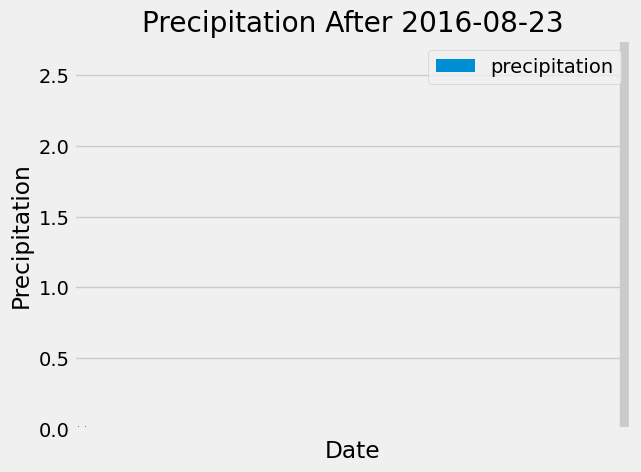

<Figure size 2000x1000 with 0 Axes>

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
# Find all dates greater than 2016-08-23
session.query(measurement.date).\
filter(measurement.date > '2016-08-23').\
order_by(measurement.date).all()

# Perform a query to retrieve the data and precipitation scores
# 10-3 activity 03
# create a select variable that grabs the precipitation data
sel = [measurement.date, measurement.prcp]

# query for the precipitation data for every day after 2016-08-23
prcp_data = session.query(*sel).\
    filter(measurement.date >= '2016-08-23').\
    group_by(measurement.date).\
    order_by(measurement.date).all()
prcp_data

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Help from Xpert Learning Assistant
prcp = {
    'date': [row[0] for row in prcp_data],
    'precipitation': [row[1] for row in prcp_data]
}
prcp_df = pd.DataFrame(prcp)

prcp_df['date'] = pd.to_datetime(prcp_df['date'])
# show sample of the df
prcp_df.head()

# Sort the dataframe by date
prcp_df_sorted = prcp_df.sort_values(by='date')
# prcp_df_sorted.head(10)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df_sorted.plot.bar(x='date', y='precipitation')
# Add labels
plt.title('Precipitation After 2016-08-23')
plt.xlabel('Date')
plt.ylabel('Precipitation')

# Set the x-axis tick marks to show only a few dates for the x-axis tick frequency (Xpert Learning Assistant)
# Select every 40th date
selected_dates = prcp_df_sorted['date'].iloc[::30]
plt.xticks(selected_dates,rotation=45)

# Figure size
plt.figure(figsize=(20,10))

plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df_sorted['precipitation'].describe()


count    364.000000
mean       0.048709
std        0.204930
min        0.000000
25%        0.000000
50%        0.000000
75%        0.020000
max        2.620000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
# 10-2 activity 01, 02
num_stations = session.query(station).count()
print(f"There are {num_stations} stations.")


There are 9 stations.


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Help from Xpert Learning Assistant

# use func.count() to count the number of rows per unique station,
# use.group_by() to group by unique station,
# use .order_by().desc() to list the most active station first,
# use .all() to list each one
most_active_stations = session.query(measurement.station, func.count(measurement.station).label('active_count')) \
                                .group_by(measurement.station) \
                                .order_by(func.count(measurement.station).desc()) \
                                .all()

# Use for loop to iterate through each station and its count (i.e. number of rows) and display the results
for station, count in most_active_stations:
    print(f"Station: {station}, Activity count: {count}")


Station: USC00519281, Activity count: 2772
Station: USC00519397, Activity count: 2724
Station: USC00513117, Activity count: 2709
Station: USC00519523, Activity count: 2669
Station: USC00516128, Activity count: 2612
Station: USC00514830, Activity count: 2202
Station: USC00511918, Activity count: 1979
Station: USC00517948, Activity count: 1372
Station: USC00518838, Activity count: 511


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# create a variable to house the min, max, and avg query functions
temp_summary_stats = [func.min(measurement.tobs),
                      func.max(measurement.tobs),
                      func.avg(measurement.tobs)]

# use the temp_summary_stats variable in the session.query()
# use the filter function to only include data from the most active station
active_station = session.query(*temp_summary_stats).\
    filter(measurement.station == "USC00519281").all()

active_station


[(54.0, 85.0, 71.66378066378067)]

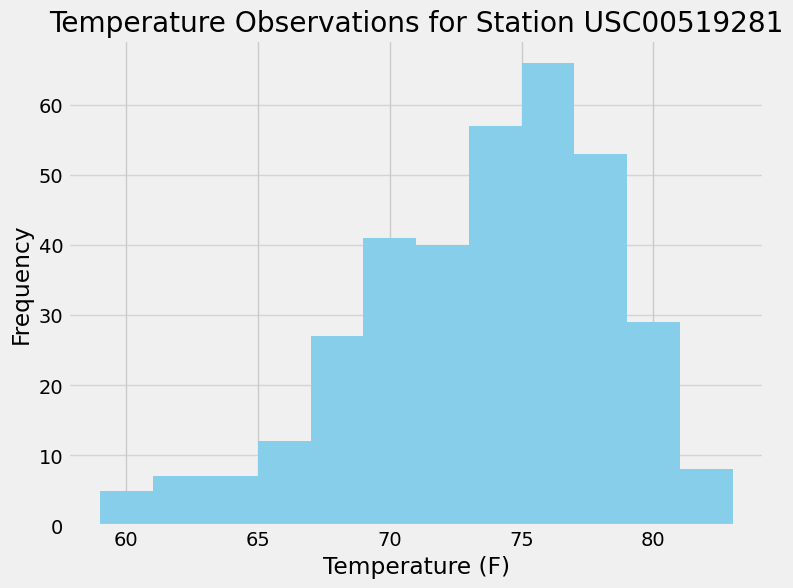

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = [measurement.tobs]

# query for the temperature data for every day after 2016-08-23
temp_data = session.query(*temp_obs).\
    filter(measurement.station == "USC00519281").\
    filter(measurement.date >= '2016-08-23').all()


    
# Pull out the temperature values from the temp_data
temperatures = [temp[0] for temp in temp_data]

# Create the histogram (help from Xpert Learning Assistant)
plt.figure(figsize=(8, 6))
# use 12 bins for the 12 months
plt.hist(temperatures, bins=12, color='skyblue')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Station USC00519281')
# add grid lines with 25% transparency (i.e. 75% opacity)
plt.grid(axis='y', alpha=0.75)
plt.show()



# Close Session

In [20]:
# Close Session
session.close()